In [1]:
import requests
import boto3
import json
import os
import sys
import argparse
import importlib
import transformers
import torch
import pathlib
import smart_open
import awswrangler as wr
from IPython.display import display
from sagemaker.huggingface.processing import HuggingFaceProcessor
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import FrameworkProcessor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.session import get_execution_role


# Adding ../01_modules or ./01_modules to the system path so that we can load modules from 
# there as well
if '__file__' in globals():
    script_dir = pathlib.Path(__file__).parent.resolve()
else:
    script_dir = pathlib.Path().absolute()
modules_path_in_dev = os.path.abspath(os.path.join(script_dir, '..', '01_modules'))
modules_path_in_prod = os.path.abspath(os.path.join(script_dir, '01_modules'))
if os.path.exists(modules_path_in_dev):
    sys.path.append(modules_path_in_dev)
if os.path.exists(modules_path_in_prod):
    sys.path.append(modules_path_in_prod)


# # Jupyter only reads a local module the first time after 
# # kernel start. Re-running a cell with 
# # "from mymodulename import *" would not change
# # anything, even if the imported module has since changed.
# # As a workaround, we need to directly load the module, 
# # use importlib.reload to reload it and then import * 
import utils
_ = importlib.reload(utils)
import config
_ = importlib.reload(config)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
config.py loaded: v0.1
utils.py loaded: v0.2.12
utils.py loaded: v0.2.12
config.py loaded: v0.1


In [2]:
database_name = '02_stg'
table_name = 'stg_filtered_work_chapters_methodology_single'
id_columns = ['work_id']
text_column_name = 'chapter_text'
text_batch_size = 100000

utils.pd_set_options(cols=100)
id_column_names = ', '.join(id_columns)
# TODO: pagination
texts_df = wr.athena.read_sql_query(f"""
    SELECT
        {id_column_names}, {text_column_name} 
    FROM
        "{database_name}".{table_name}
    ORDER BY
        {id_column_names}
    LIMIT
        {text_batch_size}
    """,
    database_name
)
texts_only_list = texts_df[text_column_name].tolist()
texts_only_list[0][0:100]

'As was noted earlier, we formed our dataset utilizing the existing relations present in SNOMED CT. T'

In [3]:
seed_topic_list = [
    [
        'measuring performance',
        'performance measurement',
        'workload characterization',
        'system profiling',
        'resource utilization',
        'latency distribution',
        'throughput measurement',
        'energy consumption',
        'error/failure rate',
        'trace collection',
        'production logs',
        'traffic analysis',
        'observational study',
        'usage statistics',
        'descriptive statistics',
        'measurement methodology',
        'measurement dataset',
        'profiling results',
        'benchmark traces',
        'observational dataset'
    ],
    [
        'online questionnaire',
        'paper questionnaire',
        'cross-sectional survey',
        'longitudinal survey',
        'survey instrument',
        'response rate',
        'sampling strategy',
        'participant recruitment',
        'informed consent',
        'participant demographics',
        'Likert scale',
        'open-ended responses',
        'semi-structured interviews',
        'structured interview',
        'unstructured interview',
        'interview protocol',
        'focus group',
        'pilot survey',
        'thematic analysis',
        'coding of responses'
    ],
    [
        'single-case study',
        'multiple-case study',
        'industrial case study',
        'field study',
        'longitudinal case study',
        'case study protocol',
        'case selection',
        'context description',
        'naturalistic setting',
        'triangulation of sources',
        'within-case analysis',
        'cross-case analysis',
        'chain of evidence',
        'practitioner interviews',
        'participant observation',
        'artifact analysis',
        'documentation analysis',
        'data sources',
        'threats to validity',
        'study site'
    ],
    [
        'formal model',
        'formal specification',
        'theoretical analysis',
        'mathematical proof',
        'correctness proof',
        'soundness proof',
        'completeness proof',
        'complexity analysis',
        'NP-hardness',
        'operational semantics',
        'denotational semantics',
        'type system',
        'invariant',
        'fixed-point',
        'convergence proof',
        'temporal logic',
        'model checking',
        'theorem prover',
        'formal verification',
        'deductive reasoning'
    ],
    [
        'systematic literature review',
        'systematic mapping study',
        'meta-analysis',
        'review protocol',
        'search string',
        'search strategy',
        'inclusion criteria',
        'exclusion criteria',
        'quality assessment',
        'data extraction',
        'coding scheme',
        'inter-rater reliability',
        'flow diagram',
        'publication bias',
        'evidence synthesis',
        'taxonomy of methods',
        'conceptual framework',
        'research gaps',
        'trend analysis',
        'study selection'
    ],
    [
        'prototype implementation',
        'reference implementation',
        'algorithm design',
        'performance evaluation',
        'controlled experiment',
        'experimental setup',
        'benchmark suite',
        'benchmark dataset',
        'evaluation metrics',
        'state-of-the-art comparison',
        'ablation study',
        'scalability evaluation',
        'stress testing',
        'simulation study',
        'emulation testbed',
        'testbed evaluation',
        'parameter settings',
        'random seed',
        'reproducibility package',
        'baseline comparison'
    ]
]

In [4]:
seed_topic_list = [
    ['measuring', 'parsing'],
    ['survey', 'interview'],
    ['case study', 'field study'],
    ['theory', 'formal'],
    ['meta analysis', 'ontology'],
    ['prototype', 'simulation'],
]

In [5]:
timelogger = utils.TimeLogger()
from bertopic import BERTopic

from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words='english')

# from transformers.pipelines import pipeline
# embedding_model = pipeline('feature-extraction', model='distilbert-base-cased')
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    embedding_model=embedding_model,
    seed_topic_list=seed_topic_list,
    # nr_topics=6
)
topics, probs = topic_model.fit_transform(texts_only_list)
timelogger.log(f'BERTopic training done')
topic_model.get_topic_info()

 :: :: TIMELOGGER STARTED :: | since_start: 0.00 seconds | since_last: 0.00 seconds :: 
 :: BERTopic training done | since_start: 1.0 minute, 37.35 seconds | since_last: 1.0 minute, 37.35 seconds :: 


,Topic,Count,Name,Representation,Representative_Docs
0,-1,12517,-1_data_students_research_learning,"[data, students, research, learning, study, used, model, based, using, information]","[To achieve the goal, a set of the following research methods was used:\n\n− Theoreticalmethod o..."
1,0,1362,0_section_feature_classifiers_ensemble,"[section, feature, classifiers, ensemble, dataset, classification, classifier, selection, data, ...",[The proposed methodology as shown in Fig. 2 integrates advanced ensemble learning techniques to...
2,1,1239,1_survey_questionnaire_respondents_interview,"[survey, questionnaire, respondents, interview, questions, participants, study, questionnaires, ...","[Mixed method approach was used-quantitative/descriptive, qualitative/interactive-for completing..."
3,2,929,2_sentiment_tweets_twitter_tweet,"[sentiment, tweets, twitter, tweet, comments, hate, posts, words, text, reviews]",[This study examines consumer opinions and attitudes towards Samsung and iPhone phones on Twitte...
4,3,551,3_speech_audio_music_speaker,"[speech, audio, music, speaker, signal, sound, voice, acoustic, asr, frequency]",[Different Studies mostly on human machine interfaces have showed that utilizing not only the av...
5,4,365,4_code_bug_software_source,"[code, bug, software, source, projects, bugs, github, refactoring, commits, test]",[The methodology for this research is divided into four steps. The first step is to identify the...
6,5,361,5_memory_gpu_cpu_cache,"[memory, gpu, cpu, cache, workloads, execution, hardware, cores, benchmarks, instructions]",[Evaluation Platforms. We evaluate our GPU implementations on two platforms. The first platform ...
7,6,344,6_recommendation_user_item_recommender,"[recommendation, user, item, recommender, rating, users, ratings, items, recommendations, simila...",[In this section we explain the proposed approach. We use the notations defined in Table 1. In r...
8,7,291,7_image_color_images_noise,"[image, color, images, noise, histogram, pixels, texture, contrast, gray, pixel]","[In this study, we propose a contrast optimization method to render a high-dynamic-range image a..."
9,8,288,8_adversarial_attack_attacks_perturbation,"[adversarial, attack, attacks, perturbation, perturbations, backdoor, adversary, adv, attacker, ...","[This section introduces the components of an RL-based recommendation system, attack techniques ..."


In [39]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
embeddings = model.encode(texts_only_list, show_progress_bar=True)

Batches:   0%|          | 0/1003 [00:00<?, ?it/s]

In [40]:
import umap
umap_embeddings = umap.UMAP(
    n_neighbors=15, 
    n_components=5, 
    metric='cosine'
).fit_transform(embeddings)

In [41]:
import hdbscan
cluster = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric='euclidean',                      
    cluster_selection_method='eom'
).fit(umap_embeddings)

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

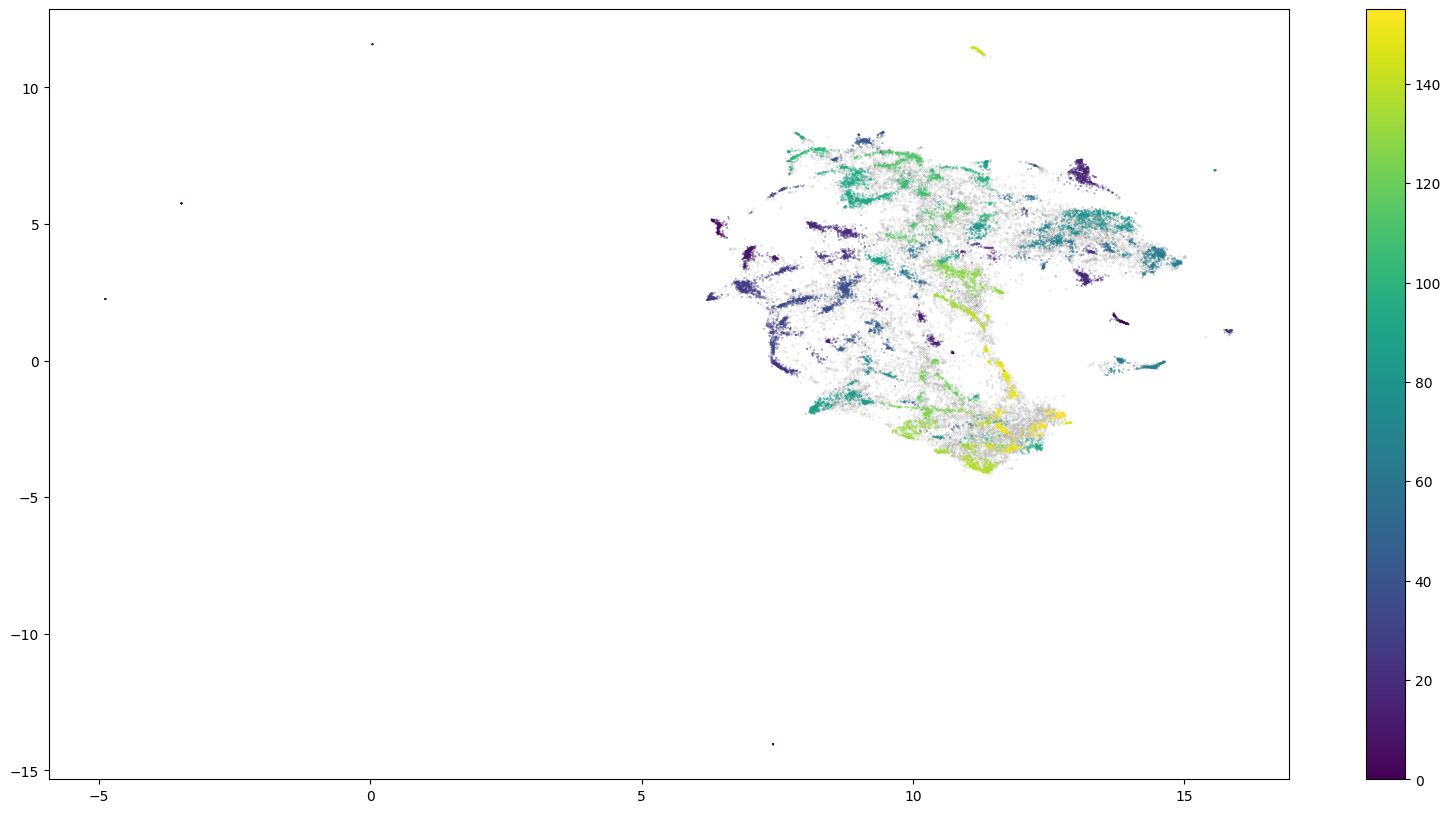

In [43]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='viridis') # 'tab20'
plt.colorbar()

In [44]:
docs_df = pd.DataFrame(texts_only_list, columns=['Doc'])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df)) # TODO: real ids
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(texts_only_list))

In [45]:
count

CountVectorizer(stop_words='english')

In [46]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
0,-1,15348
79,78,714
16,15,565
20,19,495
93,92,494
28,27,454
129,128,426
94,93,409
138,137,403
64,63,390


In [48]:
len(topic_sizes)

157

In [52]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(texts_only_list)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)

topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
0,-1,15583
59,58,761
11,10,565
68,67,509
14,13,495
21,20,454
94,93,426
69,68,409
101,100,403
27,26,398


In [51]:
len(topic_sizes)

136

In [53]:
top_n_words

{-1: [('students', 0.0031896856684169137),
  ('questions', 0.0029101990911696352),
  ('survey', 0.0028617844637648772),
  ('al', 0.002835146246348514),
  ('et', 0.0028133286972645316)],
 0: [('desk', 0.23271391327979613),
  ('basically', 0.10048964502527916),
  ('secondary', 0.0951299614212102),
  ('accessed', 0.09343054853426107),
  ('cost', 0.08321222159024032)],
 1: [('molecular', 0.03413020348466075),
  ('drug', 0.030634732146562964),
  ('protein', 0.028194893556755113),
  ('docking', 0.02494813514437107),
  ('molecules', 0.021586704027818815)],
 2: [('watermark', 0.03604614411443065),
  ('encryption', 0.03561651875258752),
  ('secret', 0.027711584964202552),
  ('bit', 0.025519861444157573),
  ('key', 0.024174135247275897)],
 3: [('adversarial', 0.06297222892860355),
  ('attack', 0.0414764671120521),
  ('attacks', 0.02669932168806763),
  ('backdoor', 0.015228727562412218),
  ('perturbation', 0.015072598351707597)],
 4: [('privacy', 0.09564102709418285),
  ('differential', 0.0295309

In [55]:
from scipy.cluster import hierarchy as sch
# Hierarchical topics
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(texts_only_list, linkage_function=linkage_function)

100%|██████████| 263/263 [00:02<00:00, 121.51it/s]


In [56]:
topic_model.visualize_topics()

In [3]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
similarities

(3, 768)


tensor([[1.0000, 0.6699, 0.1119],
        [0.6699, 1.0000, 0.0798],
        [0.1119, 0.0798, 1.0000]])

In [39]:
# Source: https://huggingface.co/sentence-transformers/static-retrieval-mrl-en-v1/blob/main/train.py

import random
import logging
from datasets import load_dataset, Dataset, DatasetDict
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers, MultiDatasetBatchSamplers
from sentence_transformers.evaluation import NanoBEIREvaluator
from sentence_transformers.models.StaticEmbedding import StaticEmbedding

from transformers import AutoTokenizer

random.seed(1)


def load_train_eval_datasets():
        print("Loading s2orc dataset...")
        s2orc_dataset = load_dataset("sentence-transformers/s2orc", "title-abstract-pair", split="train[:1000]")
        s2orc_dataset_dict = s2orc_dataset.train_test_split(test_size=100, seed=1)
        s2orc_train_dataset: Dataset = s2orc_dataset_dict["train"]
        s2orc_eval_dataset: Dataset = s2orc_dataset_dict["test"]
        print("Loaded s2orc dataset.")
    
        train_dataset = DatasetDict({
            "s2orc": s2orc_train_dataset,
        })
        eval_dataset = DatasetDict({
            "s2orc": s2orc_eval_dataset,
        })

        train_dataset.save_to_disk("datasets/train_dataset")
        eval_dataset.save_to_disk("datasets/eval_dataset")
        
        # The `train_test_split` calls have put a lot of the datasets in memory, while we want it to just be on disk
        # So we're calling quit() here. Running the script again will load the datasets from disk.
        quit()
    

def main():
    # 1. Load a model to finetune with 2. (Optional) model card data
    static_embedding = StaticEmbedding(AutoTokenizer.from_pretrained("google-bert/bert-base-uncased"), embedding_dim=1024)
    model = SentenceTransformer(
        modules=[static_embedding],
        model_card_data=SentenceTransformerModelCardData(
            language="en",
            license="apache-2.0",
            model_name="Static Embeddings with BERT uncased tokenizer finetuned on various datasets",
        ),
    )

    # 3. Set up training & evaluation datasets - each dataset is trained with MNRL (with MRL)
    train_dataset, eval_dataset = load_train_eval_datasets()
    print(train_dataset)

    # 4. Define a loss function
    loss = MultipleNegativesRankingLoss(model)
    loss = MatryoshkaLoss(model, loss, matryoshka_dims=[32, 64, 128, 256, 512, 1024])

    # 5. (Optional) Specify training arguments
    run_name = "static-retrieval-mrl-en-v1"
    args = SentenceTransformerTrainingArguments(
        # Required parameter:
        output_dir=f"models/{run_name}",
        # Optional training parameters:
        num_train_epochs=1,
        per_device_train_batch_size=2048,
        per_device_eval_batch_size=2048,
        learning_rate=2e-1,
        warmup_ratio=0.1,
        fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
        bf16=True,  # Set to True if you have a GPU that supports BF16
        batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
        multi_dataset_batch_sampler=MultiDatasetBatchSamplers.PROPORTIONAL,
        # Optional tracking/debugging parameters:
        eval_strategy="steps",
        eval_steps=250,
        save_strategy="steps",
        save_steps=250,
        save_total_limit=2,
        logging_steps=250,
        logging_first_step=True,
        run_name=run_name,  # Will be used in W&B if `wandb` is installed
    )

    # 6. (Optional) Create an evaluator & evaluate the base model
    evaluator = NanoBEIREvaluator()
    evaluator(model)

    # 7. Create a trainer & train
    trainer = SentenceTransformerTrainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        loss=loss,
        evaluator=evaluator,
    )
    trainer.train()

    # (Optional) Evaluate the trained model on the evaluator after training
    evaluator(model)

    # 8. Save the trained model
    model.save_pretrained(f"models/{run_name}/final")

    # 9. (Optional) Push it to the Hugging Face Hub
    model.push_to_hub(run_name, private=True)

if __name__ == "__main__":
    main()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.6 MB/s  0:00:00eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
 :: :: TIMELOGGER STARTED :: | since_start: 0.00 seconds | since_last: 0.00 seconds :: 


'\n@conference{schopf_etal_kdir22,\nauthor={Tim Schopf and Simon Klimek and Florian Matthes},\ntitle={PatternRank: Leveraging Pretrained Language Models and Part of Speech for Unsupervised Keyphrase Extraction},\nbooktitle={Proceedings of the 14th International Joint Conference on Knowledge Discovery, Knowledge Engineering and Knowledge Management (IC3K 2022) - KDIR},\nyear={2022},\npages={243-248},\npublisher={SciTePress},\norganization={INSTICC},\ndoi={10.5220/0011546600003335},\nisbn={978-989-758-614-9},\nissn={2184-3228},\n}\n'

In [81]:
database_name = '03_core'
table_name = 'unified_works'
id_columns = ['id']
text_column_name = 'fulltext'
text_batch_size = 1

utils.pd_set_options(cols=100)
id_column_names = ', '.join(id_columns)
# TODO: pagination
texts_df = wr.athena.read_sql_query(f"""
    SELECT
        {id_column_names}, {text_column_name} 
    FROM
        "{database_name}".{table_name}
    ORDER BY
        {id_column_names}
    LIMIT
        {text_batch_size}
    """,
    database_name
)
texts_only_list = texts_df[text_column_name].tolist()
texts_only_list[0]

'\nIntroduction\n\nAn important part of future wireless communication systems is multi-user (MU) multiple-input multiple-output (MIMO) processing. It has been shown that the linear increase of the MU MIMO systems\' data rate in the number of transmit antennas can be achieved by serving users simultaneously using the space-division multiple access (SDMA) [1]. In multi-hop-based systems additional, intermediate radio access points, or relay nodes (RNs), are used to reduce distances between individual nodes and simultaneously improve the channel conditions. The relays traditionally have been used to mitigate the effect of path loss for obtaining robust communication. The three-terminal relay channel where a single intermediate node supports a single communication pair was introduced in seminal paper [2]. Different relaying protocols which still serve as a basis for many relaying strategies were proposed later in [3]. The idea of relaying was first applied to wireless fading channels in [4

In [109]:
# sentence_transformer_model_name = 'sentence-transformers/all-mpnet-base-v2'
sentence_transformer_model_name = 'sentence-transformers/all-distilroberta-v1'

st_embed_model = SentenceTransformer(sentence_transformer_model_name)
timelogger.log('SentenceTransformer initialized')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 :: SentenceTransformer initialized | since_start: 2.0 hours, 8.0 minutes, 34.10 seconds | since_last: 54.0 minutes, 25.36 seconds :: 


' :: SentenceTransformer initialized | since_start: 2.0 hours, 8.0 minutes, 34.10 seconds | since_last: 54.0 minutes, 25.36 seconds :: '

In [110]:
timelogger.log('generic methodology phrases encoded START')
generic_methodology_phrases = [
    'research method',
    'research methodology',
    'methodological approach',
    'experimental study',
    'empirical evaluation',
    'case study',
    'simulation study',
    'measurement study',
    'formal proof'
]

generic_methodology_phrase_embeddings = st_embed_model.encode(generic_methodology_phrases)
timelogger.log('generic methodology phrases encoded END')
generic_methodology_phrase_embeddings

 :: generic methodology phrases encoded START | since_start: 2.0 hours, 8.0 minutes, 34.11 seconds | since_last: 0.01 seconds :: 
 :: generic methodology phrases encoded END | since_start: 2.0 hours, 8.0 minutes, 34.24 seconds | since_last: 0.13 seconds :: 


array([[-0.00535332, -0.00680356,  0.00489834, ...,  0.01841462,
        -0.03167965, -0.00509521],
       [-0.00022198,  0.00414012,  0.01022068, ..., -0.01404907,
        -0.03241678, -0.02545267],
       [ 0.01189187,  0.01842939,  0.0284657 , ..., -0.03430156,
        -0.0243664 , -0.03020132],
       ...,
       [-0.03220619, -0.01856576,  0.02224939, ..., -0.03424371,
        -0.04298648, -0.09180254],
       [-0.0292997 , -0.07373923, -0.00920676, ...,  0.01079469,
         0.03783653, -0.05652967],
       [ 0.03346384,  0.01161791, -0.01428203, ..., -0.0728052 ,
        -0.08783861, -0.02877215]], dtype=float32)

In [111]:
timelogger.log('text encoded START')
text_list_embeddings = st_embed_model.encode(texts_only_list)
timelogger.log('text encoded END')
text_list_embeddings

 :: text encoded START | since_start: 2.0 hours, 8.0 minutes, 34.25 seconds | since_last: 0.01 seconds :: 
 :: text encoded END | since_start: 2.0 hours, 8.0 minutes, 34.83 seconds | since_last: 0.58 seconds :: 


array([[-8.68145283e-03, -2.51142345e-02,  2.16977093e-02,
        -2.85870284e-02,  3.27077694e-02,  4.55734618e-02,
         4.37250361e-02, -6.21308619e-03,  2.23551840e-02,
        -4.74536456e-02, -2.16707382e-02, -1.47131896e-02,
         9.49765742e-03, -8.06958601e-03,  7.63178244e-03,
        -1.06652007e-02, -4.67619672e-02,  4.03063446e-02,
         1.06130861e-01,  5.98782562e-02, -1.11165433e-03,
        -1.61547996e-02, -3.47634330e-02, -1.67096574e-02,
        -3.38133238e-02, -5.47860563e-02, -1.94171444e-02,
         1.39202615e-02,  3.44496183e-02, -5.42909727e-02,
        -2.12978981e-02,  2.26298757e-02,  2.46357527e-02,
        -1.68850962e-02, -8.19400698e-02, -3.47034670e-02,
         5.49847521e-02, -1.75220110e-02, -2.89288480e-02,
        -2.06967480e-02,  1.09603209e-02, -1.87469758e-02,
         9.30347480e-03,  6.04046229e-03,  1.71626043e-02,
         3.21358442e-02,  3.05631086e-02, -3.89634669e-02,
        -8.14654585e-03, -3.22841965e-02,  5.55476174e-0

In [112]:
timelogger.log('initiate pos_vectorizer START')
pos_pattern = (
    # Verb-led methodological action (optional subject/aux/adv, main verb, noun phrase core, optional chained PPs)
    # we derive MIMO processing matrices
    # we compare the performance
    # we factor the MU MIMO precoding matrix
    '(<AUX>?<RB>?<V.*><PRT>?<DT>?<J.*>*<N.*>+(<IN><DT>?<J.*>*<N.*>+)*)' #+ '|'
    
    # Nominal methodological construct (adjective/noun/proper stacks + optional PP tails)
    # singular value decomposition
    # MIMO processing matrices
    # regularized block diagonal AF algorithm
    # '(<J.*>*<N.*>+(<N.*>+)*(<IN><J.*>*<N.*>+)*)' # + '|'
    
    # Metric/result short form
    # bit error rate
    # BER performance
    # SNR gain
    # '(<J.*>*<N.*>+)'
)
pos_vectorizer = KeyphraseCountVectorizer(
    spacy_pipeline=nlp,
    pos_pattern=pos_pattern, # '<J.*>*<N.*>+',
    # min_df=1, # cutoff
)
timelogger.log('initiate pos_vectorizer END')

 :: initiate pos_vectorizer START | since_start: 2.0 hours, 8.0 minutes, 35.07 seconds | since_last: 0.24 seconds :: 
 :: initiate pos_vectorizer END | since_start: 2.0 hours, 8.0 minutes, 35.07 seconds | since_last: 0.00 seconds :: 


' :: initiate pos_vectorizer END | since_start: 2.0 hours, 8.0 minutes, 35.07 seconds | since_last: 0.00 seconds :: '

In [113]:
timelogger.log('initiate keybert_model START')
keybert_model = KeyBERT(model=st_embed_model)
timelogger.log('initiate keybert_model END')

 :: initiate keybert_model START | since_start: 2.0 hours, 8.0 minutes, 38.59 seconds | since_last: 3.52 seconds :: 
 :: initiate keybert_model END | since_start: 2.0 hours, 8.0 minutes, 38.59 seconds | since_last: 0.00 seconds :: 


' :: initiate keybert_model END | since_start: 2.0 hours, 8.0 minutes, 38.59 seconds | since_last: 0.00 seconds :: '

In [118]:
print(sentence_transformer_model_name)
timelogger.log('extract 100 keywords START')
initial_keywords_top100 = keybert_model.extract_keywords(  # TODO: consider using this with candidates=[...] for the next round
    docs=texts_only_list,
    top_n=100,
    vectorizer=pos_vectorizer,
    use_maxsum=True,
    nr_candidates=100
)
initial_keyword_embeddings = st_embed_model.encode([kw[0] for kw in initial_keywords_top100])
timelogger.log('extract 100 keywords END')
initial_keywords_top100

sentence-transformers/all-distilroberta-v1
 :: extract 100 keywords START | since_start: 2.0 hours, 11.0 minutes, 2.27 seconds | since_last: 6.24 seconds :: 
 :: extract 100 keywords END | since_start: 2.0 hours, 11.0 minutes, 5.85 seconds | since_last: 3.58 seconds :: 


[('rewrite equation', 0.0461),
 ('block', 0.051),
 ('denotes identity matrix', 0.0525),
 ('denotes additive noise correlation matrix', 0.053),
 ('proposed algorithm performance system', 0.0561),
 ('using binary phase shift keying', 0.0592),
 ('denote algorithm', 0.062),
 ('central node', 0.0625),
 ('significantly reduces practicality algorithm', 0.0632),
 ('assuming large path loss', 0.067),
 ('reducing overlap row spaces', 0.0673),
 ('feedback noise variance', 0.071),
 ('consider uts', 0.0719),
 ('diagonal positive definite power', 0.0837),
 ('provide reliable transmission', 0.0869),
 ('design mimo', 0.0874),
 ('compare bit error rate', 0.09),
 ('received power kth ut', 0.0949),
 ('perform mimo', 0.095),
 ('diagonal matrix r', 0.0986),
 ('reduce distances individual nodes', 0.0997),
 ('find optimum f.', 0.1016),
 ('neglecting direct links bs uts', 0.102),
 ('serving users', 0.1024),
 ('using zf beam', 0.1031),
 ('consider mse uts', 0.1082),
 ('kth ut mimo', 0.1084),
 ('using method la

In [106]:
timelogger.log('extract 100 keywords START')
initial_keywords_top100 = keybert_model.extract_keywords(  # TODO: consider using this with candidates=[...] for the next round
    docs=texts_only_list,
    top_n=100,
    vectorizer=pos_vectorizer
)
initial_keyword_embeddings = st_embed_model.encode([kw[0] for kw in initial_keywords_top100])
timelogger.log('extract 100 keywords END')
initial_keywords_top100

 :: extract 100 keywords START | since_start: 1.0 hour, 14.0 minutes, 2.27 seconds | since_last: 0.38 seconds :: 
 :: extract 100 keywords END | since_start: 1.0 hour, 14.0 minutes, 8.74 seconds | since_last: 6.47 seconds :: 


[('assuming mu mimo channel', 0.5829),
 ('design mu mimo', 0.5529),
 ('design mimo', 0.5449),
 ('find optimum mimo processing matrices', 0.5336),
 ('perform mimo', 0.5299),
 ('limitations mimo processing matrices', 0.5292),
 ('resulting mimo processing matrices', 0.5119),
 ('jointly optimizes mimo processing matrices bs', 0.5002),
 ('using mimo channel matrices bs rn', 0.4936),
 ('consider mu mimo dl system', 0.4799),
 ('derive mimo processing matrices', 0.4728),
 ('factor mu mimo', 0.4699),
 ('rn mimo', 0.4653),
 ('design mimo processing matrices bs', 0.4631),
 ('extend mimo', 0.4596),
 ('estimate effective mimo matrix', 0.4501),
 ('using mimo channel matrix bs rn', 0.4466),
 ('function mimo processing matrix', 0.4409),
 ('multiple antennas', 0.4325),
 ('derive mimo processing matrices bs', 0.4223),
 ('derived mimo processing matrices bs', 0.4211),
 ('assuming mimo', 0.42),
 ('kth ut mimo', 0.4147),
 ('fading channels', 0.4047),
 ('minimize mui kth ut co - channel uts', 0.3998),
 ('pr

In [107]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

top_n = 10
pairwise_distances = euclidean_distances(initial_keyword_embeddings, generic_methodology_phrase_embeddings)
closest_distances_per_keyword = [[index, min(ds)] for index, ds in enumerate(pairwise_distances)]
sorted_closest_distances_per_keyword = sorted(closest_distances_per_keyword, key=lambda x: x[1])
keywords = [initial_keywords_top100[index][0] for (index, distance) in sorted_closest_distances_per_keyword]
keywords

['present results simulations',
 'estimates h',
 'proposed algorithm performance system',
 'perform resource allocation',
 'proposed system',
 'estimate h',
 'compare performance rbd af algorithm',
 'received power kth ut',
 'compare bit error rate',
 'describe relaying system',
 'estimate h 2,k f r k',
 'denotes number',
 'investigate different power allocation algorithms',
 'using following optimization',
 'using matrices f r',
 'design mimo',
 'provide information additive noise variances receivers transmitters',
 'describe antenna configuration system',
 'perform mimo',
 'design mu mimo',
 'optimize kth ut performance',
 'denotes kth ut',
 'channel estimation errors',
 'negligible performance loss',
 'provide reliable transmission',
 'estimate effective mimo matrix',
 'serving users',
 'multi - user',
 'receive matrices rn',
 'consider mu mimo dl system',
 'receive matrix rn',
 'minimizes mu interference',
 'kth ut mimo',
 'minimize mu interference',
 'denotes additive noise correl

In [70]:
closest_distances_per_keyword

[[0, 1.4426476], [1, 1.4687278]]

In [63]:
distances

array([[1.4426476, 1.4526964],
       [1.4687278, 1.4915861]], dtype=float32)